# Installation

```bash
pip install pandas numpy matplotlib
```

If you get an error of `Original error was: libf77blas.so.3: cannot open shared object file: No such file or directory` (hiding at the very bottom of the error message) and are running Jupyter on a Raspberry Pi then:

```bash
sudo apt-get install libatlas-base-dev
```

In [33]:
## SETUP
# uncomment the next line if needed - likely one once
# ! pip install pandas numpy matplotlib

# Set the K value that was used for these tests
start_k = 0.05291351624874463

# Set to the value of the target volume - in liters
target_volume = 2

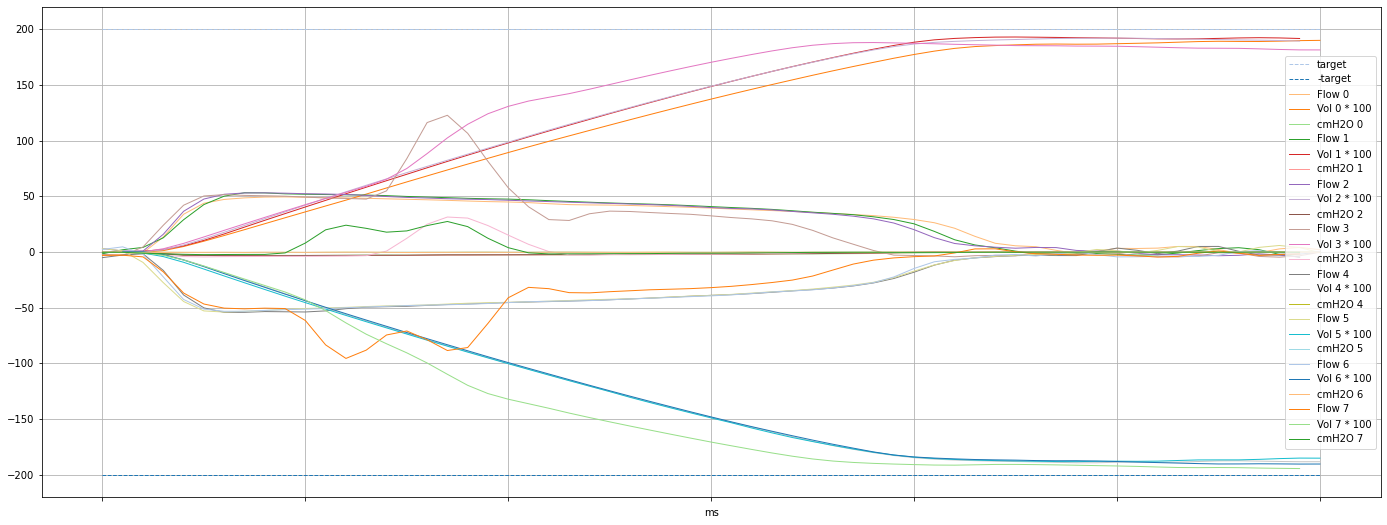

In [37]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Some formatting setup

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#aec7e8', '#1f77b4', '#ffbb78', '#ff7f0e', '#98df8a','#2ca02c', 
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
plt.rcParams['lines.linewidth'] = 1

import glob
csv_files = sorted(glob.glob("./cal-v32.2-2020-06-29-*.csv"))

ax = None
new_ks = []
dfs = []

n = 0

for file_name in csv_files:

    # Read in the file, and shift it to the start of the test
    df = pd.read_csv(file_name, sep="\t")

    # Trim everything before 3 samples before flow goes over 10slm
    df = df.shift(3-df[abs(df['flow']) > 10].index[0])

    # start the ms counter at the beginning of the kept region
    df['ms'] = pd.to_timedelta(df['ms'], unit='s')
    first_ms = df['ms'][0]
    df['ms'] = df['ms'] - first_ms

    # keep only 4 seconds
    first_index_past_4_seconds = df[df['ms'] > pd.to_timedelta('4s')].index[0]+2
    df = df[:first_index_past_4_seconds]

    # Compute the volume - step 1, ms per sample
    # ms_diff = df['ms'] - df.shift(1, fill_value=0)['ms']
    ms_diff = df['ms'].diff()/pd.to_timedelta('1m')

    # Compute the volume - step 2, volume change per sample, adjusted SLM to L/s
    volume_temp = ms_diff * df['flow']

    # Compute the volume - step 3, cumulative sum
    df['volume'] =  volume_temp.cumsum()

    # Now for charting we'll add a volume * 100
    df['volume_100'] = df['volume'] * 100

    # And add a line for the target volume
    df['target'] = target_volume * 100
    df['-target'] = -target_volume * 100

    # Add a max volume mark
    df['volume_100_max'] = df['volume_100'].max()

    if ax is None:
        ax = df.plot(x='ms', y=['target', '-target'], style="--", grid=True, figsize=[24, 10])

    ax = df.plot(ax=ax, x='ms', y=['flow', 'volume_100', 'pressure_cmh2o'], label=[f'Flow {n}', f'Vol {n} * 100', f'cmH2O {n}'], grid=True)
    # ax = df.flow.plot(ax=ax, label=f'Flow {n}')
    # ax = df.volume_100.plot(ax=ax, label=f'Vol {n} * 100')
    # ax = df.pressure_cmh2o.plot(ax=ax, label=f'cmH2O {n}')
    
    # Compute the adjusted K
    new_k = start_k * (target_volume / max(abs(df['volume'].min()), df['volume'].max()))
    new_ks.append(new_k)

    dfs.append(df)

    n += 1

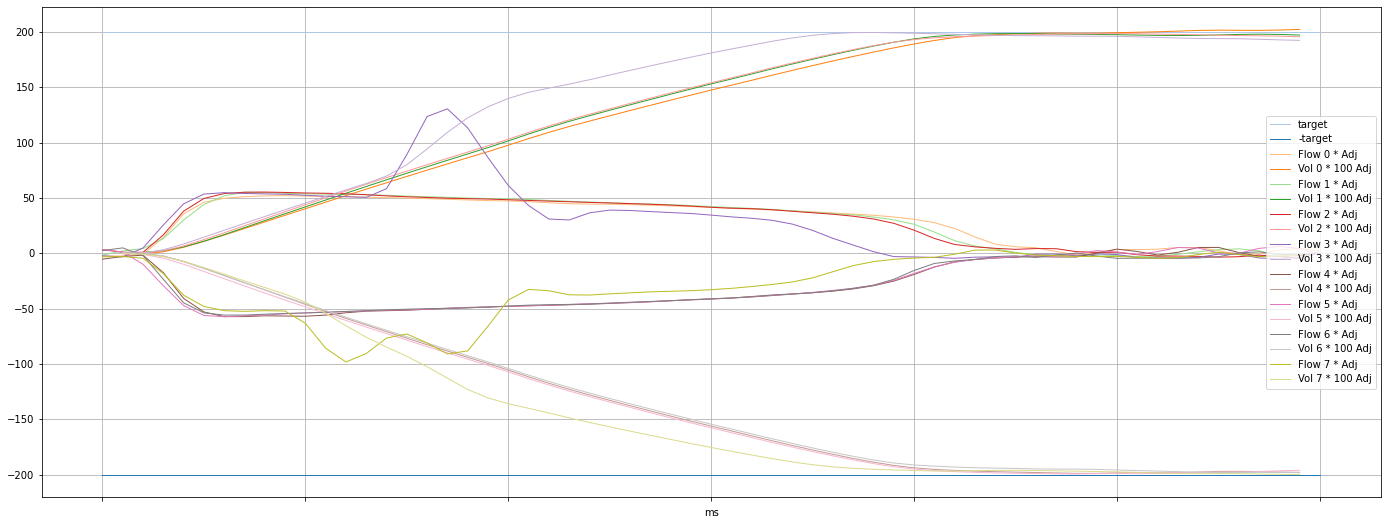

In [35]:
new_k = pd.Series(new_ks).median()

ax2 = None
n = 0

for df in dfs:
    # Compute the new volume - step 1, compute an adjusted flow
    df['flow_adj'] = (df['flow']/start_k)*new_k

    # Compute the new volume - step 2, volume change per sample, adjusted SLM to L/s
    volume_adj_temp = ms_diff * df['flow_adj']

    # Compute the volume - step 3, cumulative sum
    df['volume_adj'] =  volume_adj_temp.cumsum()

    # Now for charting we'll add a volume * 100
    df['volume_adj_100'] = df['volume_adj'] * 100

    # Add a max volume mark
    df['volume_adj_100_max'] = df['volume_adj_100'].max()

    # ax = df.plot(ax=ax, x='ms', y=['flow_adj', 'volume_adj_100', 'volume_adj_100_max'], grid=True, figsize=[24, 10])
    ax = df.plot(ax=ax, x='ms', y=['volume_adj_100'], grid=True, figsize=[24, 10])
    ## NOW TO FIX It
    # Compute the adjusted K
    new_k = start_k * (target_volume / max(abs(df['volume'].min()), df['volume'].max()))
    # new_k = 0.055584538155867676
    new_ks.append(new_k)

    # Compute the new volume - step 1, compute an adjusted flow
    df['flow_adj'] = (df['flow']/start_k)*new_k

    # Compute the new volume - step 2, volume change per sample, adjusted SLM to L/s
    volume_adj_temp = ms_diff * df['flow_adj']

    # Compute the volume - step 3, cumulative sum
    df['volume_adj'] =  volume_adj_temp.cumsum()

    # Now for charting we'll add a volume * 100
    df['volume_adj_100'] = df['volume_adj'] * 100

    # Add a max volume mark
    df['volume_adj_100_max'] = df['volume_adj_100'].max()

    if ax2 is None:
        ax2 = df.plot(x='ms', y=['target', '-target'], grid=True, figsize=[24, 10])

    ax2 = df.plot(ax=ax2, x='ms', y=['flow_adj'], label=[f'Flow {n} * Adj'], grid=True, figsize=[24, 10])
    ax2 = df.plot(ax=ax2, x='ms', y=['volume_adj_100'], label=[f'Vol {n} * 100 Adj'], grid=True, figsize=[24, 10])

    n += 1

In [36]:
new_k

0.054378002651187994